In [31]:
# import system modules
import sys
import os
import gc

# import standard numerical modules
import numpy as np
import math

# import machine learning modules
import tensorflow as tf
import keras.backend as K


sys.path.append('../20240503')
import DCTR


In [32]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/../20240503/DCTR.py'>

In [33]:
# directory with pre converted lhe files as numpy arrays
data_dir = '../Data' # modify as needed


In [34]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair; every event has order: 
# tt-pair, top, anti-top
# every particle has arguments: 
# [pt, y, phi, mass, eta, E, PID, w, theta]
# [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
# plotting data; different from training data
X0_plt = []
X0_plt = np.load(f'{data_dir}/POWHEG_hvq/showered/converted_lhe_03.npy')[:9543943] # 9543943 num of MiNNLO samples
print('POWHEG hvq all particles X0_plt.shape: '+str(X0_plt.shape))

X0_test = []
X0_test = np.load(f'{data_dir}/POWHEG_hvq/showered/normed_lhe_03.npy')[:9543943]
print('POWHEG hvq all particles X0_test.shape: '+str(X0_test.shape))


POWHEG hvq all particles X0_plt.shape: (9543943, 3, 9)
POWHEG hvq all particles X0_test.shape: (9543943, 3, 9)


In [35]:
# MiNNLO
# plotting data
X1_plt = []
X1_plt = np.load(f'{data_dir}/MiNNLO/showered/converted_lhe.npy')
print(f'{np.shape(X1_plt) = }')

X1_nrm = []
X1_nrm = np.load(f'{data_dir}/MiNNLO/showered/normed_lhe.npy')
print(f'{np.shape(X1_nrm) = }')


np.shape(X1_plt) = (9543943, 3, 9)
np.shape(X1_nrm) = (9543943, 3, 9)


In [36]:
# get event generator weights

X0_plt_wgt = X0_plt[:, 0, 7].copy()
X1_plt_wgt = X1_plt[:, 0, 7].copy()
X1_nrm_wgt = X1_nrm[:, 0, 7].copy()

print(X0_plt_wgt)
print(X1_plt_wgt)
print(X1_nrm_wgt)


[ 692.452  692.452  692.452 ...  691.115 -691.115  691.115]
[-103.245  103.245 -103.245 ...  103.245  103.245  103.245]
[-1.  1. -1. ...  1.  1.  1.]


In [37]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_test = np.delete(X0_test, 5, -1)

# delete eta
X0_test = np.delete(X0_test, 4, -1)

# garbage collection after deleting to clear memory asap
print(gc.collect())


1901


In [38]:
model = './train_20240522/super_epoch_6/run_0/s-6_b-131072_r-0.tf' # path to previously trained model (in .tf format (folder))

# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_test) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0].copy(), X0_plt_wgt)


2024-05-31 17:03:29.183673: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 572636580 exceeds 10% of free system memory.


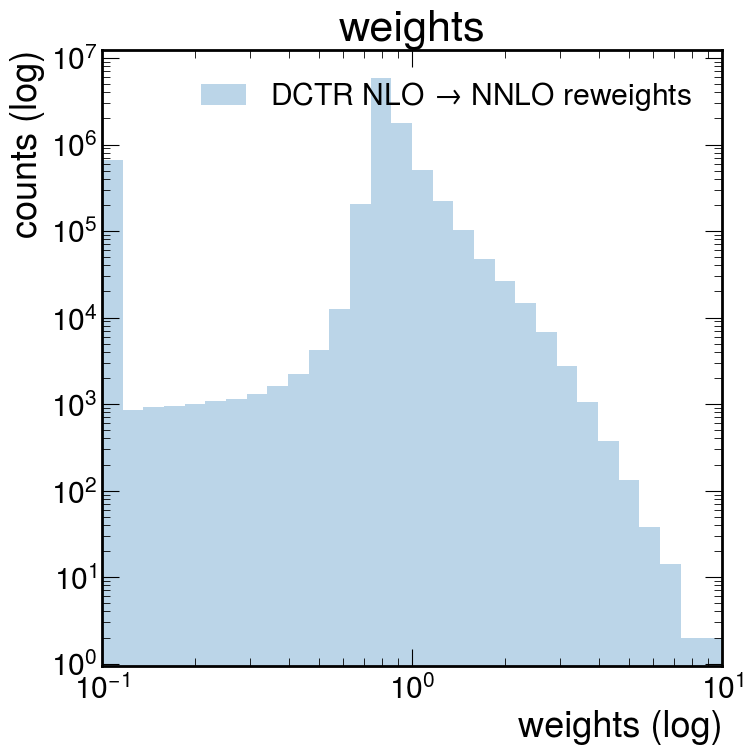

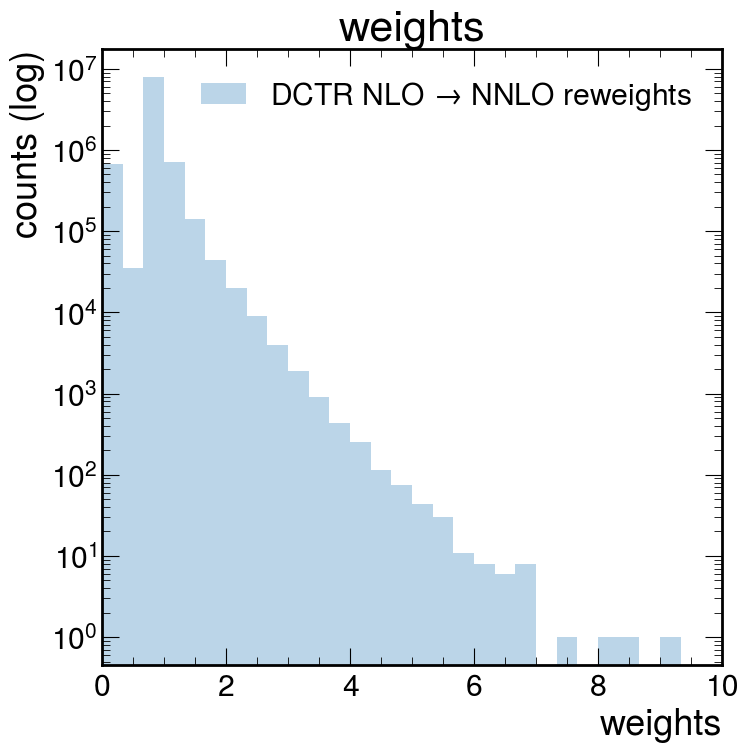

In [40]:
# plot and check dctr rwgt
wgts = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts, start = 0.1, stop = 10) # log
DCTR.plot_weights(wgts, start = 0, stop = 10, xscale='lin') # linear 


In [45]:
# check weights
print(f'Weights (min, max, mean): \n\
    MiNNLO X1: {min(X1_nrm_wgt), max(X1_nrm_wgt), np.mean(X1_nrm_wgt)} \n\
    DCTR:      {min(dctr_rwgt[0]), max(dctr_rwgt[0]), np.mean(dctr_rwgt[0])}')


X0_sum_wgt = len(X0_plt) # assuming wgt = 1 for all events | 
X1_sum_wgt = np.sum(X1_nrm_wgt) # all wgt = +/- 1 
DCTR_sum_rwgt = np.sum(dctr_rwgt[0])
print(f'Sum of Weights: \n\
    {X0_sum_wgt                 = } \n\
    {X1_sum_wgt                 = } \n\
    {DCTR_sum_rwgt              = }')


X0_sum_wgt_squared = len(X0_plt) # all = 1
X1_sum_wgt_squared = np.sum(np.power(X1_nrm_wgt, 2)) # should also equal len(X1_nrm_wgt)
DCTR_sum_rwgt_squared = np.sum(np.power(dctr_rwgt[0], 2))
print(f'Sum of Squared Weights: \n\
    {X0_sum_wgt_squared         = } \n\
    {X1_sum_wgt_squared         = } \n\
    {DCTR_sum_rwgt_squared      = }')


sqrt_X0_sum_wgt_squared = np.sqrt(X0_sum_wgt_squared)
sqrt_X1_sum_wgt_squared = np.sqrt(X1_sum_wgt_squared)
sqrt_DCTR_sum_rwgt_squared = np.sqrt(DCTR_sum_rwgt_squared)
print(f'Square Root of Sum of Squared Weights: \n\
    {sqrt_X0_sum_wgt_squared    = } \n\
    {sqrt_X1_sum_wgt_squared    = } \n\
    {sqrt_DCTR_sum_rwgt_squared = }')


X0_mean_wgt = 1.0
X1_mean_wgt = np.mean(X1_nrm_wgt)
DCTR_mean_rwgt = np.mean(dctr_rwgt[0])
print(f'Mean of Weights: \n\
    {X0_mean_wgt                = } \n\
    {X1_mean_wgt                = } \n\
    {DCTR_mean_rwgt             = }')


X0_std_wgt = 0.0
X1_std_wgt = np.std(X1_nrm_wgt)
DCTR_std_rwgt = np.std(dctr_rwgt[0])
print(f'Standard Deviation of Weights: \n\
    {X0_std_wgt                 = } \n\
    {X1_std_wgt                 = } \n\
    {DCTR_std_rwgt              = }')


ratio_sqrt_sum_sqrt = sqrt_X0_sum_wgt_squared/sqrt_DCTR_sum_rwgt_squared
print(f'Ratio of NLO/rwgt: \n\
    {ratio_sqrt_sum_sqrt        = }')



X0_sum_wgt_absolute = len(X0_plt) # all = 1
X1_sum_wgt_absolute = np.sum(np.absolute(X1_nrm_wgt)) # should also equal len(X1_nrm_wgt)
DCTR_sum_rwgt_absolute = np.sum(np.absolute(dctr_rwgt[0]))
print(f'Sum of Absolute Weights: \n\
    {X0_sum_wgt_absolute         = } \n\
    {X1_sum_wgt_absolute         = } \n\
    {DCTR_sum_rwgt_absolute      = }')


ratio_sum_absolute = X0_sum_wgt_absolute/DCTR_sum_rwgt_absolute
print(f'Ratio of NLO/rwgt: \n\
    {ratio_sum_absolute    = }')



Weights (min, max, mean): 
    MiNNLO X1: (-1.0, 1.0, 0.8052259951678253) 
    DCTR:      (0.0, 9.152455, 0.80871594)
Sum of Weights: 
    X0_sum_wgt                 = 9543943 
    X1_sum_wgt                 = 7685031.0 
    DCTR_sum_rwgt              = 7718339.0
Sum of Squared Weights: 
    X0_sum_wgt_squared         = 9543943 
    X1_sum_wgt_squared         = 9543943.0 
    DCTR_sum_rwgt_squared      = 6994990.5
Square Root of Sum of Squared Weights: 
    sqrt_X0_sum_wgt_squared    = 3089.3272730482927 
    sqrt_X1_sum_wgt_squared    = 3089.3272730482927 
    sqrt_DCTR_sum_rwgt_squared = 2644.8044
Mean of Weights: 
    X0_mean_wgt                = 1.0 
    X1_mean_wgt                = 0.8052259951678253 
    DCTR_mean_rwgt             = 0.80871594
Standard Deviation of Weights: 
    X0_std_wgt                 = 0.0 
    X1_std_wgt                 = 0.5929680402062033 
    DCTR_std_rwgt              = 0.2808966
Ratio of NLO/rwgt: 
    ratio_sqrt_sum_sqrt        = 1.1680739877782018
Su

In [10]:
# setup args for plotting
args = [(X1_plt, X1_plt_wgt, 'NNLO (MiNNLO)'),
        (X0_plt, X0_plt_wgt, 'NLO (hvq)'),
        (X0_plt, rwgt, 'dctr reweighted')]


# Paper Plots

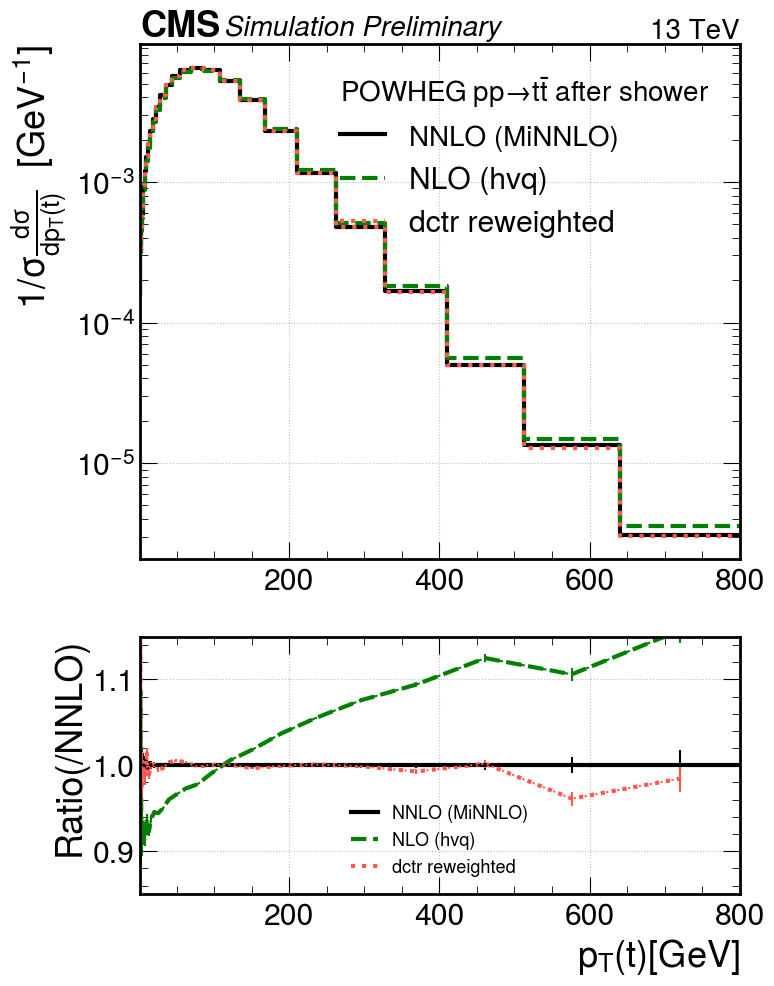

In [11]:
# p_t(t) log binning
log_bins = np.logspace(np.log10(1), np.log10(800), 31)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=1, bins=log_bins, y_scale='log', ratio_ylim=[0.85, 1.15], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_log_0800_31')


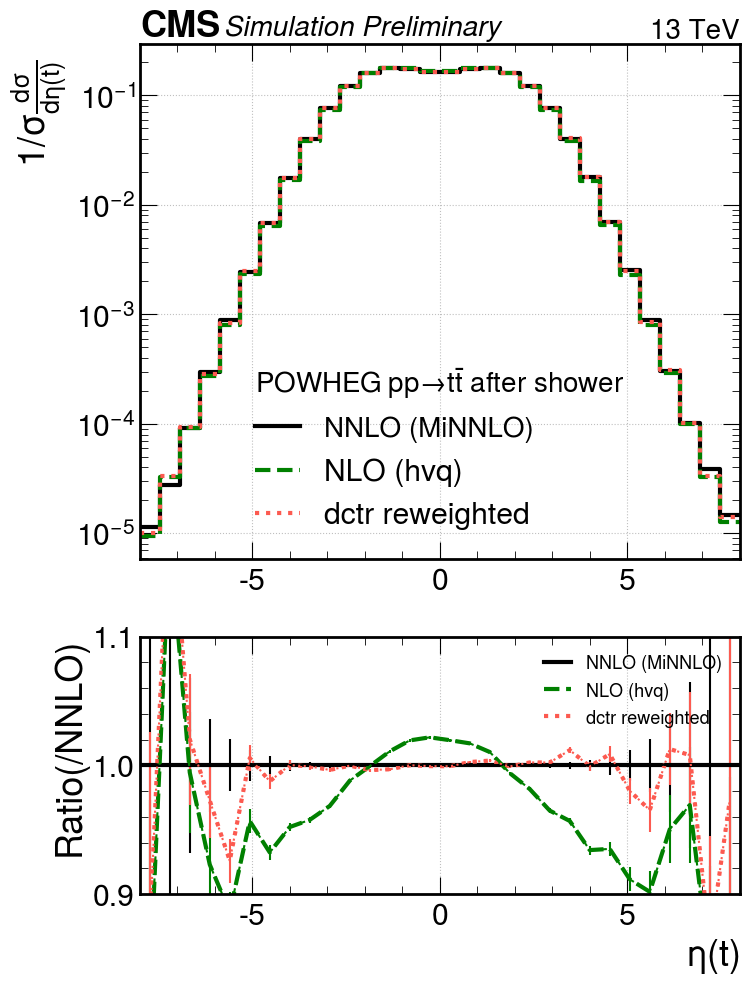

In [12]:
# eta(t) +/- 8
lin_bins = np.linspace(-8, 8, 31)
DCTR.plot_ratio_cms(args, arg_index=4, part_index=1, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_lin_pm8_31')


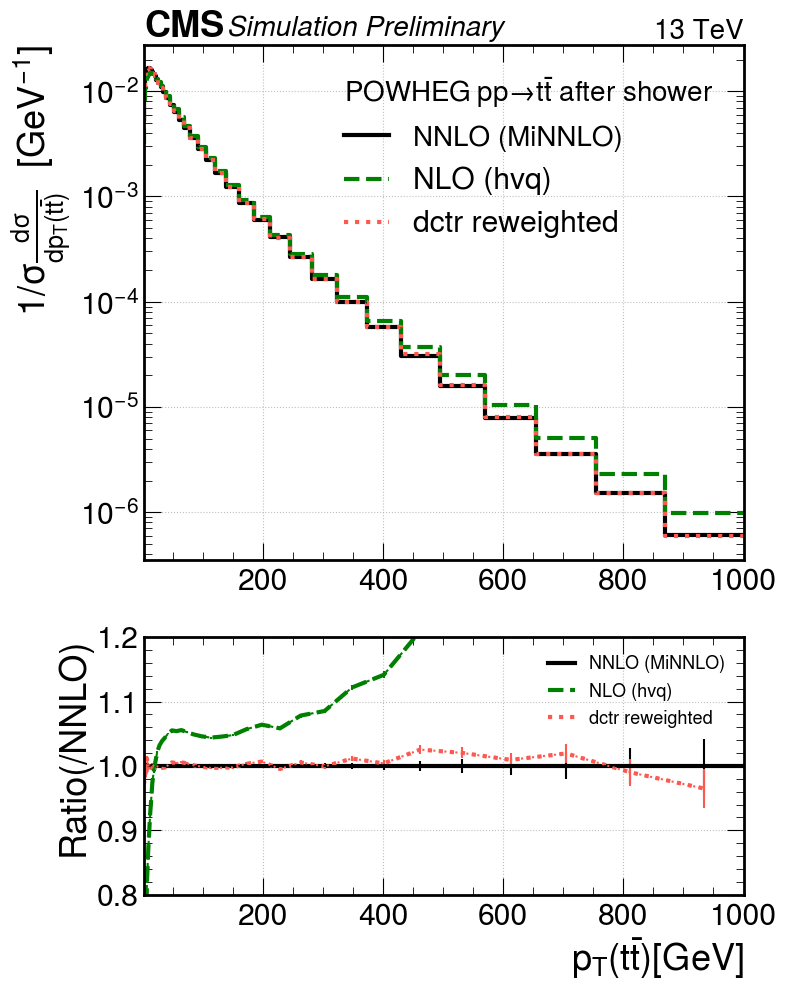

In [13]:
# p_t(tt) log binning
log_bins = np.logspace(np.log10(1), np.log10(1000), 50)
DCTR.plot_ratio_cms(args, arg_index=0, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.80, 1.20], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'showered_log_1000_50')


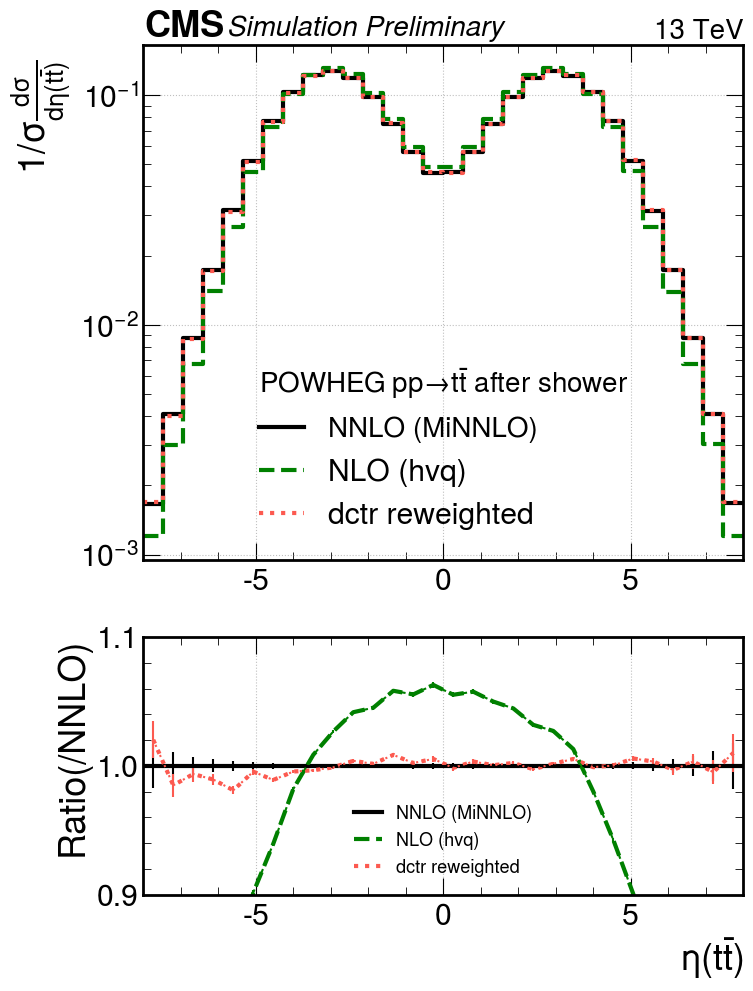

In [14]:
# eta(tt) +/- 8
lin_bins = np.linspace(-8, 8, 31)
DCTR.plot_ratio_cms(args, arg_index=4, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'lin_pm8_31')


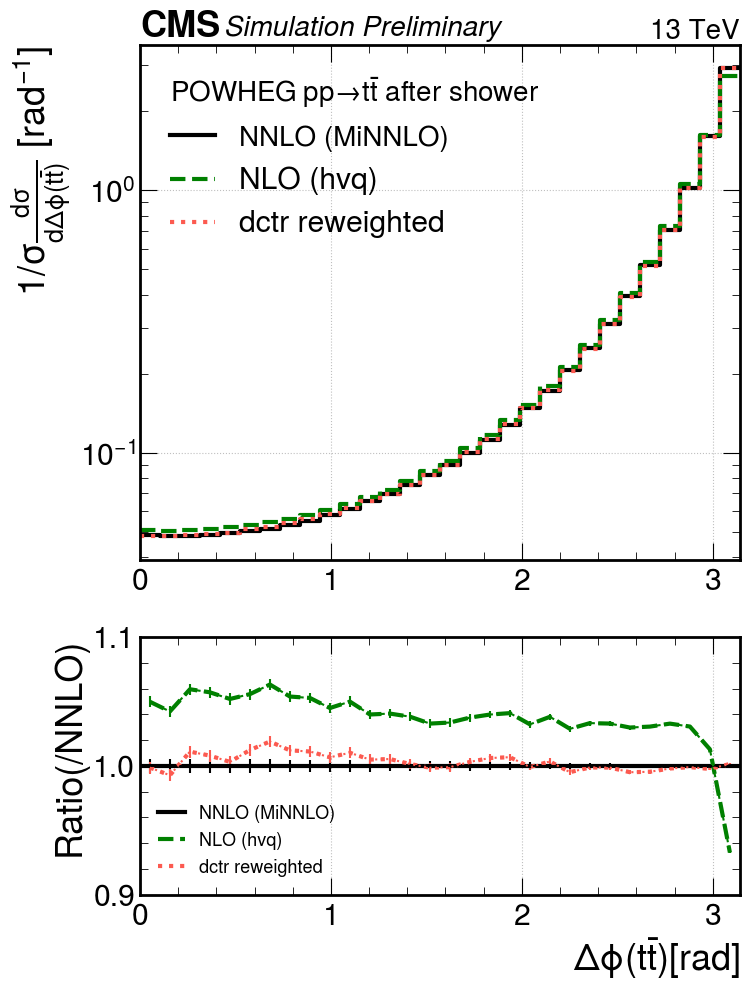

In [15]:
# delta phi
X0_delta_phi = DCTR.delta_phi(X0_plt)
X1_delta_phi = DCTR.delta_phi(X1_plt)

args_delta_phi = [(X1_delta_phi, X1_plt_wgt, 'NNLO (MiNNLO)'), 
                  (X0_delta_phi, X0_plt_wgt, 'NLO (hvq)'),
                  (X0_delta_phi, rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_delta_phi, start = 0, stop = math.pi, div=31, part_label=r't \bar{t}', arg_label=r'\Delta \phi', unit='[rad]', inv_unit='[rad$^{-1}$]', y_scale='log', pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix='lin_pi_31')


In [16]:
# find min values for E and m
min_E_tt = min(X1_plt[:, 0,5]) # min E tt (NNLO)
print(min_E_tt)

min_E_t = min(X1_plt[:, 1,5]) # min E t  (NNLO)
print(min_E_t)

min_m_tt = min(X1_plt[:, 0,3]) # min m tt (NNLO)
print(min_m_tt)


329.56989484655963
0.0
322.91461566907526


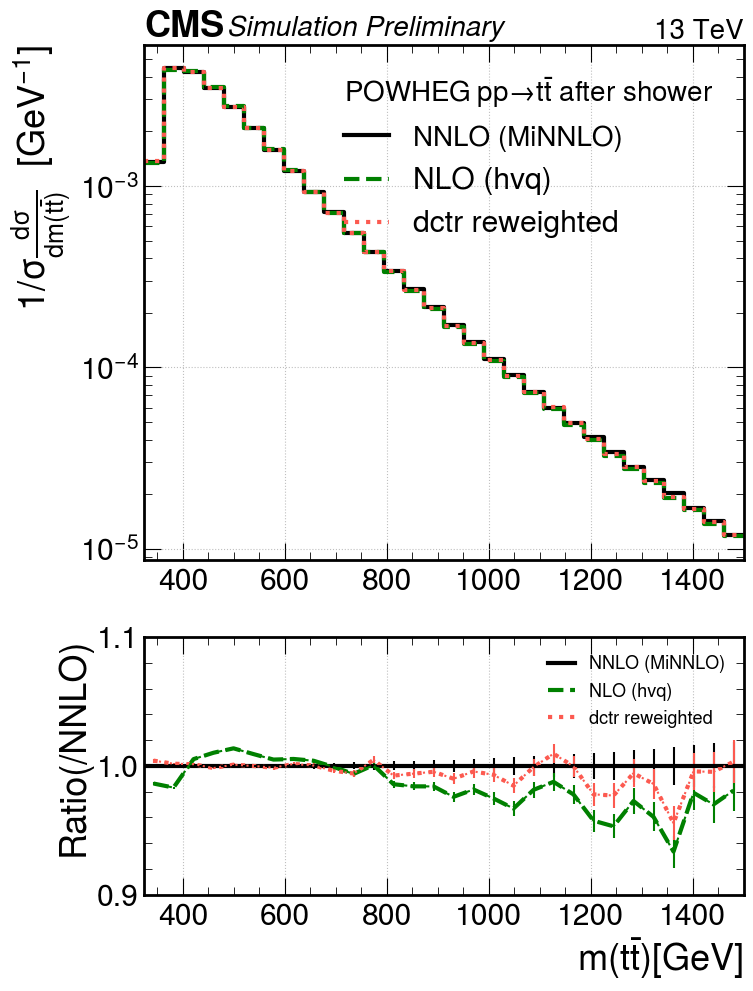

In [17]:
# m(tt) min(X1[:,])
lin_bins = np.linspace(min_m_tt, 1500, 31)
DCTR.plot_ratio_cms(args, arg_index=3, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'lin_min-1500_31')


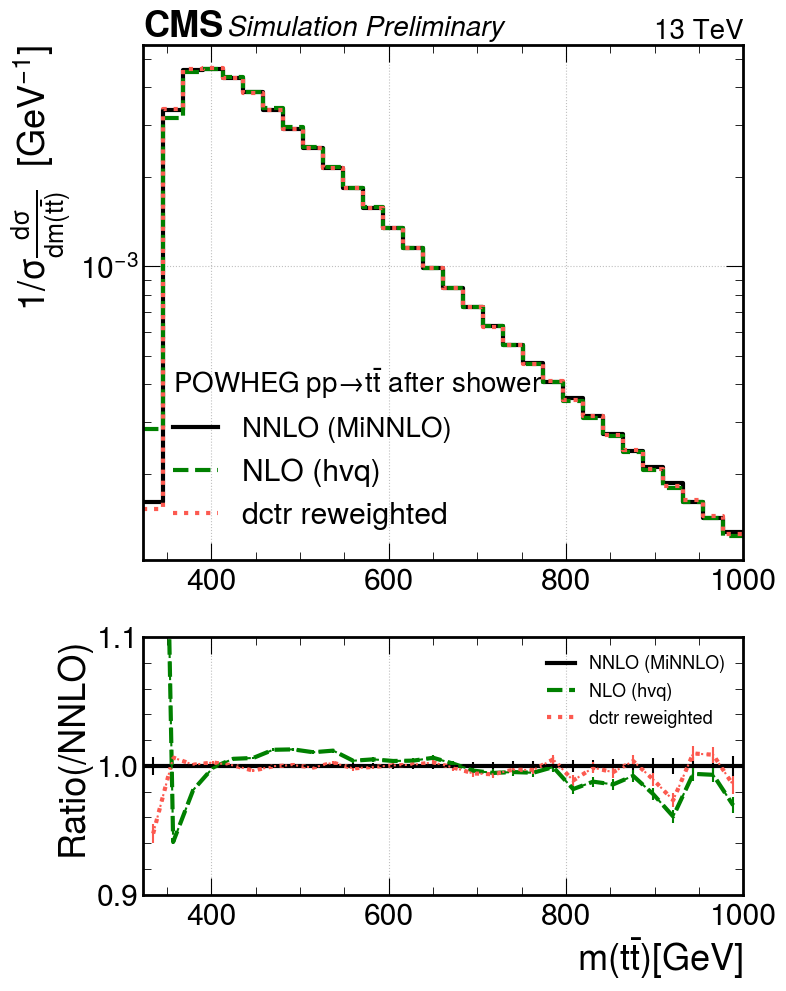

In [18]:
# m(tt) min(X1[:,])
lin_bins = np.linspace(min_m_tt, 1000, 31)
DCTR.plot_ratio_cms(args, arg_index=3, part_index=0, bins=lin_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'lin_min-1000_31')


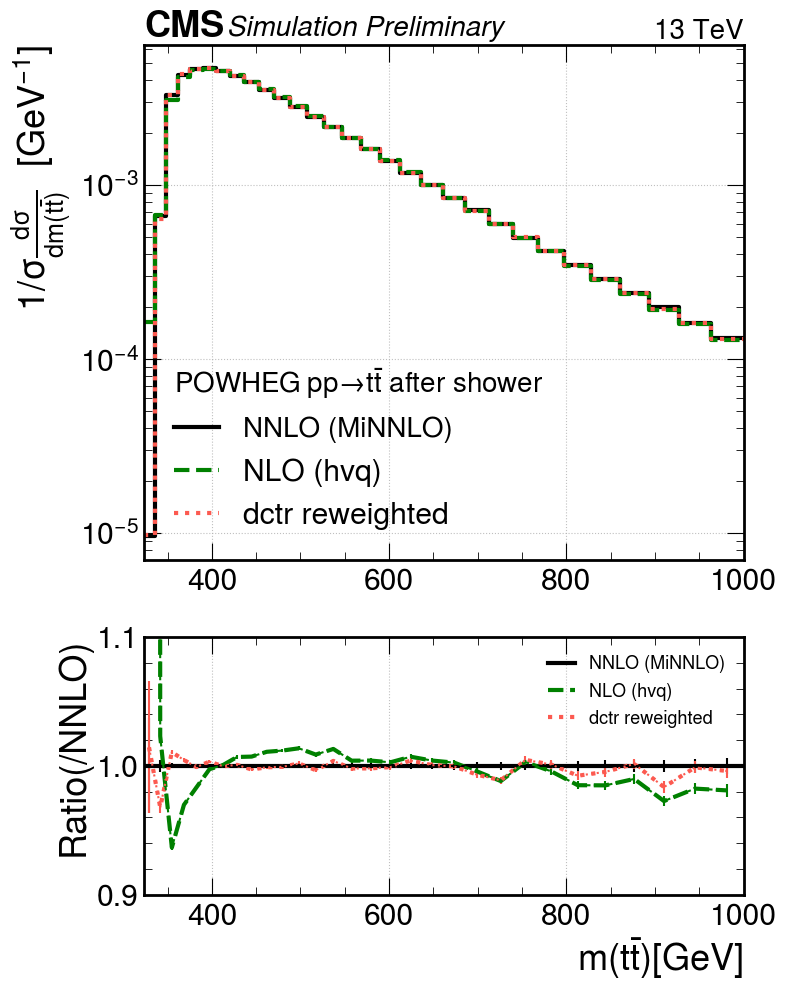

In [19]:
# m(tt) min(X1[:,])
log_bins = np.logspace(np.log10(min_m_tt), np.log10(1000), 31)
DCTR.plot_ratio_cms(args, arg_index=3, part_index=0, bins=log_bins, y_scale='log', ratio_ylim=[0.90, 1.10], pythia_text=r'$POWHEG \; pp \to  t\bar{t}$ after shower', save_prefix = 'log_min-1000_31')
